# Speech Recognition using CDHMMs

In [1]:
import os
import MFCC
import re
import random
import numpy as np
from hmmlearn import hmm
from scipy.io import wavfile
from scipy.special import logsumexp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

## Problem 1

Write a function `sample_gmmhmm` which accepts an integer $T$, and draws $T$ samples from the GMMHMM given in the lab pdf.

Use your function to draw $T=900$ samples from the GMMHMM.
Use `sklearn.decomposition.PCA` with 2 components to plot the observations in two-dimensional space. 
Color the observations by state.
How many distinct clusters do you see?

Hint: the function `np.random.choice` will be useful for drawing the hidden states and the GMM components, and `np.random.multivariate_normal` for the observation sequence. 
When plotting the samples, using the keyword argument `c` in `plt.scatter` allows you to specify the colors of the individual points.

In [19]:
def sample_gmmhmm(T):
    """
    Simulate from the GMMHMM given in the problem, returning T samples.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    N = 3
    K = 5
    M = 4
    
    ## Define the GMMHMM parameters
    # NxN transition matrix 
    A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])
    # NxK collection of component weights
    weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], 
                        [.1, .3, .2, .1, .3]])
    # NxKxM collection of component means
    means = np.array([np.floor(np.random.uniform(-100, 100, size = (5, 4))) 
                            for i in range(3)])
    # NxKx(MxM) collection of component covariance matrices       
    covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) 
                            for i in range(5)] for j in range(3)])
    # (N,) ndarray initial state distribution 
    pi = np.array([.15, .15, .7])
    

    # Determine the hidden state
    h = np.random.choice(N, p=pi)

    observations = np.zeros((T, M))
    states = np.zeros(T, dtype=int)
    
    for t in range(T):

        # sample the categorical distribution for the component
        k = np.random.choice(K, p=weights[h])

        # find the correct mean and covariance for the hidden state and component
        means_sample = means[h, k]
        covars_sample = covars[h, k]

        # sample from the multivariate normal
        obs = np.random.multivariate_normal(means_sample, covars_sample)

        # Store the state and observation
        states[t] = h
        observations[t] = obs

        # Determine the next hidden state
        h = np.random.choice(N, p=A[h])


        # Update the hidden state

    return states, observations

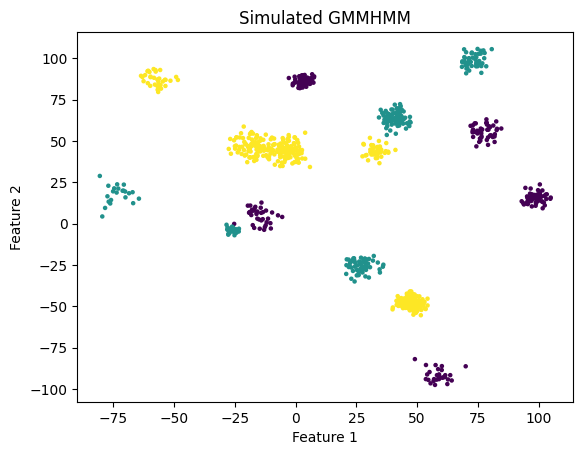

In [24]:
# sample from the GMMHMM
states, obs = sample_gmmhmm(900)

# PCA
pca = PCA(n_components=2)

# plot the samples
plt.scatter(obs[:,0], obs[:,1], c=states, s=5, cmap='viridis')
plt.title('Simulated GMMHMM')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Problem 2

In the remainder of this lab, we will create a speech recognition system for the vocabulary of the following five words/phrases: "biology", "mathematics", "political science", "psychology", and "statistics".

The `Samples` folder contains 30 recordings for each of the words/phrases in the vocabulary.
These audio samples are 2 seconds in duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed integers in WAV format. 
For each of the words, create a list holding the MFCC coefficients of the recordings of that word.

The function `scipy.io.wavfile.read` can be used to load the sound files, and the function `extract` in `MFCC.py` implements the MFCC coefficient algorithm.

In [40]:
# Dictionary to hold the MFCC coefficients
mfcc_coeffs = {
    'Biology': [],
    'Mathematics': [],
    'PoliticalScience': [],
    'Psychology': [],
    'Statistics': []
}

# Loop through the files in the Samples directory
for file in os.listdir('Samples'):

    filename = 'Samples/' + file

    # Extract the subject from the filename
    subject = file.split(' ')[0]

    # Read the wav file
    samplerate, sound_data = wavfile.read(filename)

    # Extract the MFCC coefficients
    mfcc = MFCC.extract(sound_data)

    # Append the MFCC coefficients to the dictionary
    mfcc_coeffs[subject].append(mfcc)

/var/folders/6r/hg6ljwj9053_dvzxcp0nfzsm0000gn/T/ipykernel_86935/2601026155.py:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, sound_data = wavfile.read(filename)


## Problem 3

For each word, randomly split the list of MFCCs into a training set of 20 samples and a test set of the remaining 10 samples.

Use the training sets to train GMMHMMs on each word in the vocabulary.
For each word in the vocabulary, train 10 GMMHMMs on the training set, using `n_components=5`.
Keep the model with the highest log-likelihood for each word.

In [46]:
best_models = {}

training_sets = {}
testing_sets = {}
for subject in mfcc_coeffs:

    num_models = 10

    # load the data and separate into 2/3 training and 1/3 testing
    data = mfcc_coeffs[subject]
    random.shuffle(data)

    # separate the data into training and testing
    training = data[:int(len(data)*2/3)]
    testing = data[int(len(data)*2/3):]

    training_sets[subject] = training
    testing_sets[subject] = testing

    # hmmlearn expects the data to be in a single array:
    data_collected = np.vstack(training)

    # To separate the sequences, it requires the length of each:
    lengths = [item.shape[0] for item in training]

    # Initialize and train the model
    models = [hmm.GMMHMM(n_components=5, covariance_type="diag") for _ in range(num_models)]
    for i in range(num_models):
        models[i].fit(data_collected, lengths)

    # Check the log likelihood of the models
    log_likelihoods = [model.monitor_.history[-1] for model in models]

    # Choose the best model
    best_model = models[np.argmax(log_likelihoods)]
    best_models[subject] = best_model
    

## Problem 4

Write a `predict` function for your speech recognition model.
In this function:
 - Accept the MFCC coefficients of the speech sample to be predicted.
 - Find the log probability density of the coefficients for each word's GMMHMM.
 - Return the word with the highest probability as the speech recognition model's prediction.

In [47]:
def predict(mfcc_coeff):
    scores = {}

    # iterate through the subjects
    for subject in mfcc_coeffs:

        # get the best model for the subject
        model = best_models[subject]

        # find the score of the model
        score = model.score(mfcc_coeff)

        # store the score
        scores[subject] = score

    return max(scores, key=scores.get)

## Problem 5

For each of the five test sets, call your `predict` function on each sample, and find the proportion of each test set that your model predicts correctly.
Display your results.
How well does your model perform on this dataset?

In [53]:
for subject in testing_sets:
    correct = 0
    total = 0
    for mfcc_coeff in testing_sets[subject]:
        prediction = predict(mfcc_coeff)
        if prediction == subject:
            correct += 1
        total += 1
    print(f'{subject} accuracy: {correct/total}')

Biology accuracy: 1.0
Mathematics accuracy: 1.0
PoliticalScience accuracy: 1.0
Psychology accuracy: 0.9
Statistics accuracy: 1.0
